### EDA for data about amount of people working after 1 year of finishing their studies. 

TODO:  
- Create functions so it can be implemented with Taipy. 
- "Clean" data so it is easier to gather insights/plot/etc if necessary.  
#

- Find interesting information & trends.
- Create plots.
- See if KPIs can be extracted. 


Note: #### Changed data, did not like initial from SCB.
Note: ####### Check if initial data I have is wrong on the new set for amount of exa/study



In [8]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import plotly.express as px

In [9]:
#Load data, remove first column, set name of columns
df_total_inom_yrket = pd.read_excel("../../data/arb_inom_yrk_yh_exa/total_arb_inom_yrke.xlsx")
df_stor_del_inom_yrket = pd.read_excel("../../data/arb_inom_yrk_yh_exa/stor_mest_inom_yrke.xlsx")
df_viss_del_inom_yrket = pd.read_excel("../../data/arb_inom_yrk_yh_exa/viss_del_inom_yrke.xlsx")
df_ej_inom_yrket = pd.read_excel("../../data/arb_inom_yrk_yh_exa/inte_alls_inom_yrke.xlsx")


In [10]:
# Test to clean DF, worked. extracting core-df from files. 

df = df_total_inom_yrket.iloc[:, 1:]

# Step 1: Get new column names from row 1 (index 1)
new_cols = df.iloc[1, 1:6+1].astype(int).tolist()  # Select columns 1 to 6 (Unnamed: 2 to Unnamed: 6)
print(new_cols)

# Step 2: Assign new names
df.columns = ["Inriktning"] + new_cols  # First column (index 0) is "Inriktning"

# Step 3: Drop the first two rows (they were headers/empty)
df_test = df.iloc[2:16].reset_index(drop=True)

df_test.head(20)



[2020, 2021, 2022, 2023, 2024]


,Inriktning,2020,2021,2022,2023,2024
0,data/It,1086.0,1246.0,1991.0,2818.0,2372.0
1,"ekonomi, administration och försäljning",3666.0,4194.0,4936.0,5190.0,4273.0
2,friskvård och kroppsvård,80.0,94.0,105.0,118.0,123.0
3,"hotell, restaurang och turism",494.0,548.0,736.0,723.0,638.0
4,hälso- och sjukvård samt socialt arbete,2041.0,2741.0,2765.0,3376.0,3510.0
5,journalistik och information,164.0,221.0,244.0,205.0,203.0
6,juridik,98.0,94.0,140.0,131.0,91.0
7,"kultur, media och design",679.0,660.0,828.0,891.0,785.0
8,"lantbruk, djurvård, trädgård, skog och fiske",291.0,387.0,423.0,491.0,504.0
9,pedagogik och undervisning,345.0,354.0,417.0,550.0,503.0


In [11]:
def clean_custom(df):
    df = df.iloc[:, 1:].copy()


    new_cols = df.iloc[1, 1:6+1].astype(int).tolist() 

    df.columns = ["Inriktning"] + new_cols  
    df = df.iloc[2:16].reset_index(drop=True)

    return df

df_total_inom_yrket_cut = clean_custom(df_total_inom_yrket)
df_stor_del_inom_yrket_cut = clean_custom(df_stor_del_inom_yrket)
df_viss_del_inom_yrket_cut = clean_custom(df_viss_del_inom_yrket)
df_ej_inom_yrket_cut = clean_custom(df_ej_inom_yrket)




In [12]:


df_total_inom_yrket_cut

df_stor_del_inom_yrket_cut #Missing data for friskvård 22-23

df_viss_del_inom_yrket_cut #Missing data for friskvård 21/23

df_ej_inom_yrket_cut ##Missing data for friskvård 22/23

df_total_inom_yrket_cut

df_total = df_total_inom_yrket_cut
df_stor = df_stor_del_inom_yrket_cut
df_viss = df_viss_del_inom_yrket_cut
df_ej = df_ej_inom_yrket_cut

df_stor.head(50)

,Inriktning,2020,2021,2022,2023,2024
0,data/It,73.0,72.0,70,71,62.0
1,"ekonomi, administration och försäljning",75.0,70.0,70,71,69.0
2,friskvård och kroppsvård,46.0,73.0,..,..,60.0
3,"hotell, restaurang och turism",37.0,30.0,47,48,45.0
4,hälso- och sjukvård samt socialt arbete,65.0,65.0,66,64,61.0
5,journalistik och information,50.0,60.0,61,70,53.0
6,juridik,58.0,52.0,49,56,54.0
7,"kultur, media och design",69.0,66.0,69,71,59.0
8,"lantbruk, djurvård, trädgård, skog och fiske",66.0,75.0,72,65,68.0
9,pedagogik och undervisning,59.0,56.0,70,59,50.0


### PoC: what can be done with data, generated for PoC

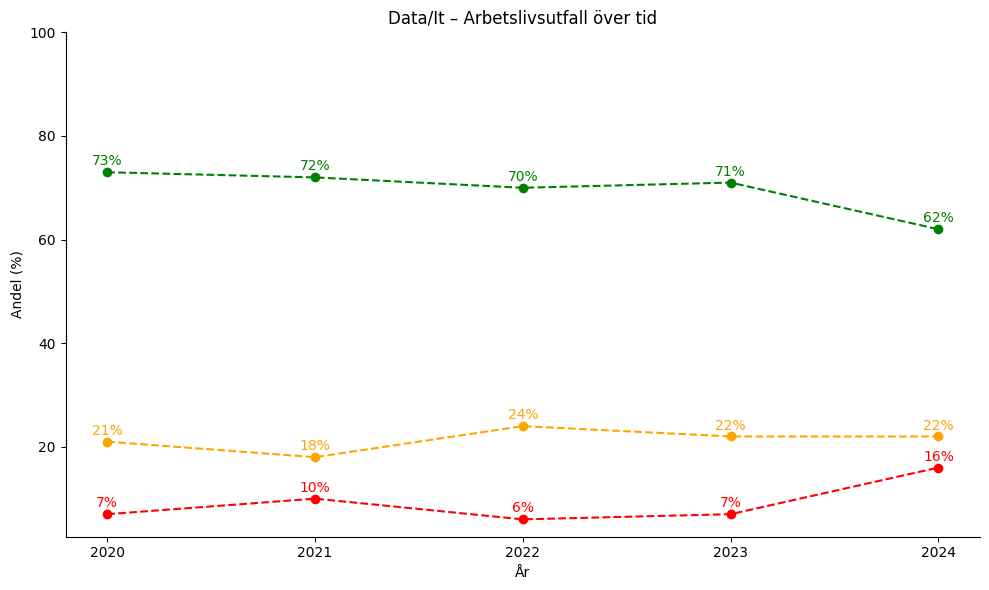

In [13]:
def plot_employment_outcomes(area, df_stor, df_viss, df_ej):
    years = df_stor.columns[1:].astype(str)

    
    stor = pd.to_numeric(df_stor[df_stor["Inriktning"] == area].iloc[0, 1:], errors="coerce")
    viss = pd.to_numeric(df_viss[df_viss["Inriktning"] == area].iloc[0, 1:], errors="coerce")
    ej = pd.to_numeric(df_ej[df_ej["Inriktning"] == area].iloc[0, 1:], errors="coerce")

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(years, stor, label="Stor del inom yrket", color="green", marker="o", linestyle="--")
    ax.plot(years, viss, label="Viss del inom yrket", color="orange", marker="o", linestyle="--")
    ax.plot(years, ej, label="Ej inom yrket", color="red", marker="o", linestyle="--")


    for i, value in enumerate(stor):
        ax.annotate(f"{value:.0f}%", (i, value), textcoords="offset points", xytext=(0,5), ha='center', color='green')
    for i, value in enumerate(viss):
        ax.annotate(f"{value:.0f}%", (i, value), textcoords="offset points", xytext=(0,5), ha='center', color='orange')
    for i, value in enumerate(ej):
        ax.annotate(f"{value:.0f}%", (i, value), textcoords="offset points", xytext=(0,5), ha='center', color='red')


    ax.set_title(f"{area.title()} – Arbetslivsutfall över tid")
    ax.set_xlabel("År")
    ax.set_ylim(top=100)
    ax.set_ylabel("Andel (%)")
    ax.grid(False)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_employment_outcomes("data/It", df_stor, df_viss, df_ej)
